# Compare signal and background distribution

## Load data and perform basic checks

In [1]:
from root_pandas import read_root
import matplotlib.pyplot as plt
import glob
import pandas as pd

Welcome to JupyROOT 6.18/00


In [2]:
# This makes pandas show all the columns
pd.set_option('display.max_columns', None)
plt.rc('figure', figsize = (8, 6))
plt.rc('font', size = 14)
plt.rc('hist', bins = 200)

In [3]:
%time sig = read_root('../data/mc_sig.root', 'Lambda')

CPU times: user 23.4 s, sys: 854 ms, total: 24.3 s
Wall time: 24.6 s


In [4]:
%time bkg = read_root('../data/mc_bkg.root', 'Lambda')

CPU times: user 28.6 s, sys: 1.16 s, total: 29.8 s
Wall time: 30.3 s


Check the number of signals and backgrounds.

In [5]:
sig.shape

(5951133, 33)

In [6]:
bkg.shape

(7917399, 33)

In [7]:
def plot_run(data):
    runs = sorted(data.__run__.unique())
    if len(runs) >= 20:
        runs = runs[::len(runs)//10]
    subtotal = [len(data[data.__run__ <= run]) for run in runs]
    plt.plot(runs, subtotal, marker = 'o')
    plt.xlabel('Run number')
    plt.ylabel('Cummulative number of candidates')
    plt.xticks(runs)
    plt.show()

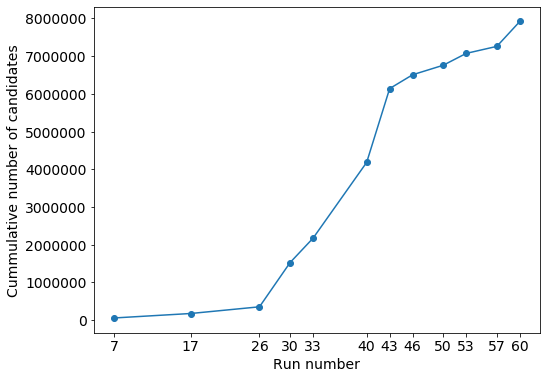

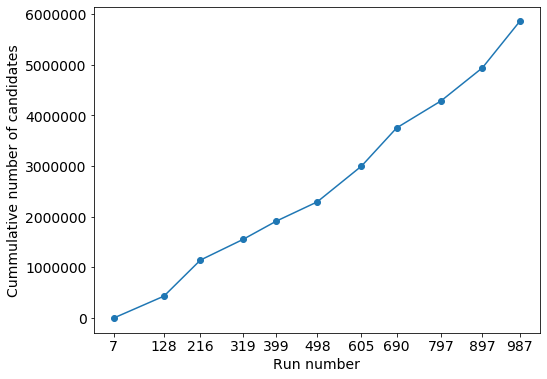

In [8]:
plot_run(bkg)
plot_run(sig)

Make sure signal file only contains signal and background file only contains background.

In [9]:
assert sum(bkg.isSignal == 0) == len(bkg), "Backgrond file contains signal!"
assert sum(sig.isSignal == 1) == len(sig), "Backgrond file contains signal!"

Check for NAN in the data.

In [10]:
bkg.isna().any().any(), sig.isna().any().any()

(False, False)

## Compare signal and background distribution

In [45]:
def plot_sig_bkg(sig, bkg):
    fig = plt.figure()
    for v in sig.columns:
        if v.startswith('__') or v.startswith('is'):
            continue
        elif 'PDG' in v:
            continue
        plot_range = None
        if v in ['dr', 'min_dr', 'distance']:
            plot_range = [0, 10]
        elif v == 'dz':
            plot_range = [-5, 5]
        elif v == 'min_dz':
            plot_range = [0, 5]
        elif v in ['p', 'pt', 'pz', 'proton_p']:
            plot_range = [0, 3]
        elif v in ['pi_p']:
            plot_range = [0, 1]
        elif v in ['M']:
            plot_range = [1.10, 1.13]
        plt.hist(sig[v], density = True, label = 'signal', histtype = 'step', range = plot_range)
        plt.hist(bkg[v], density = True, label = 'background', histtype= 'step', range = plot_range)
        plt.title(v)
        plt.legend()
        plt.show()
    return fig

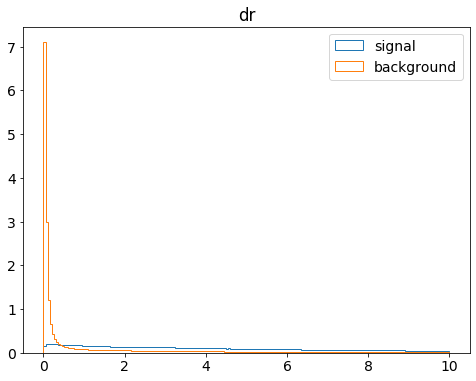

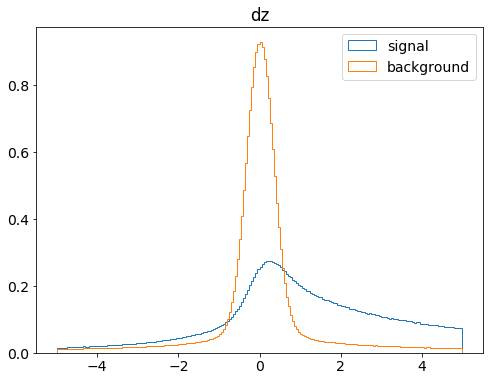

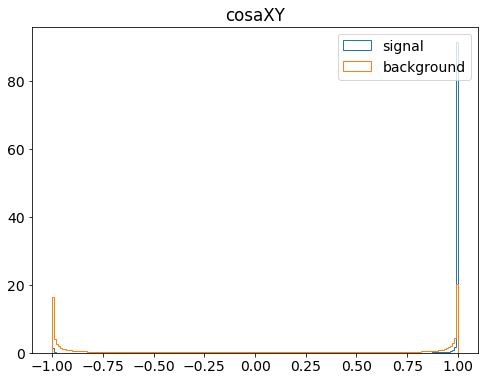

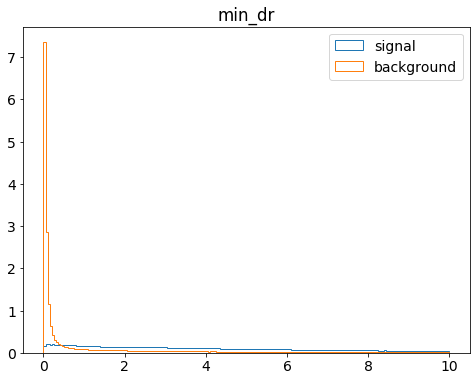

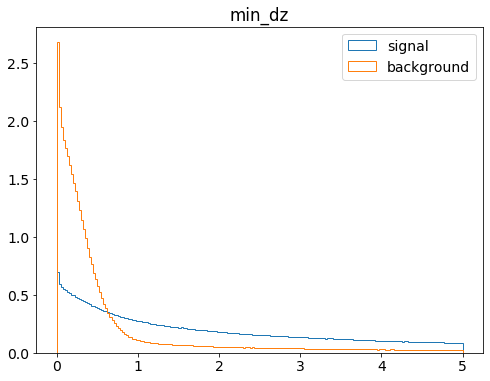

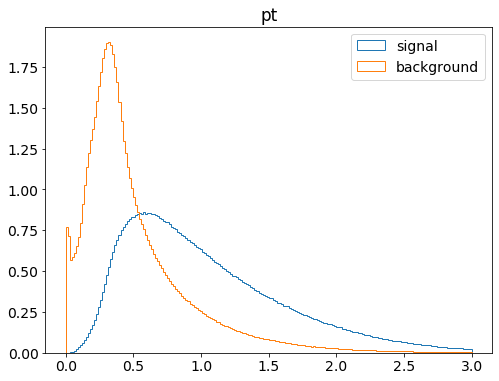

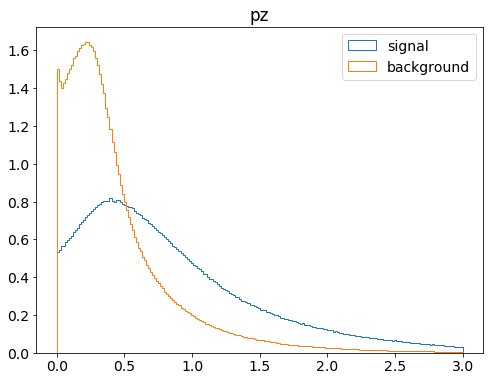

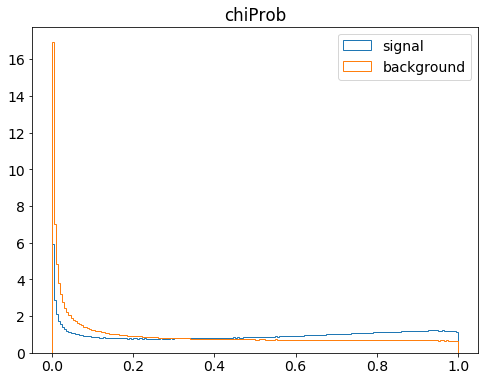

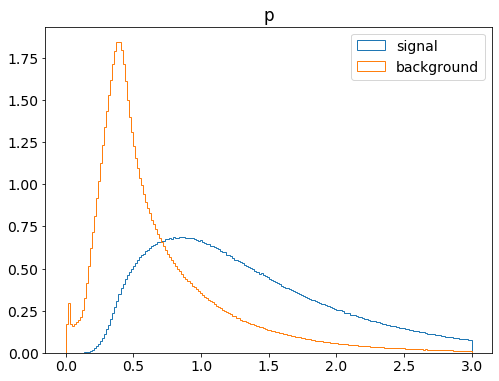

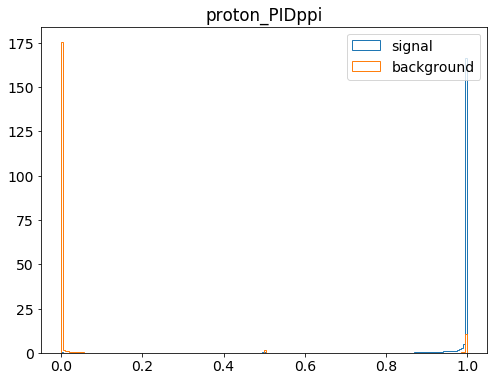

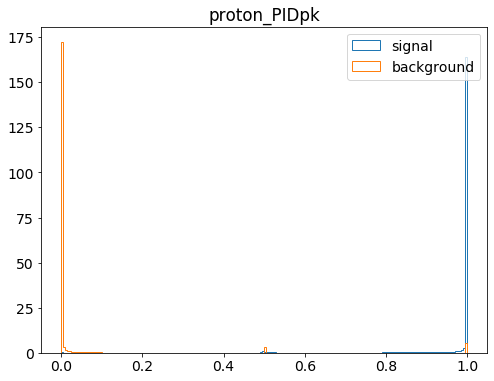

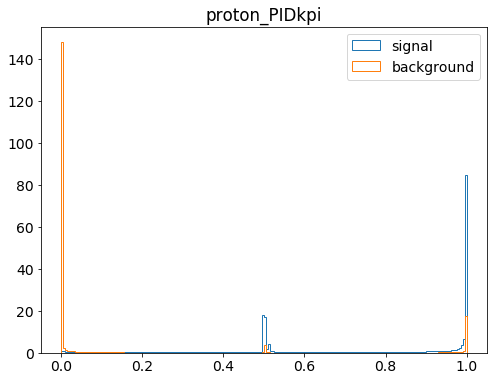

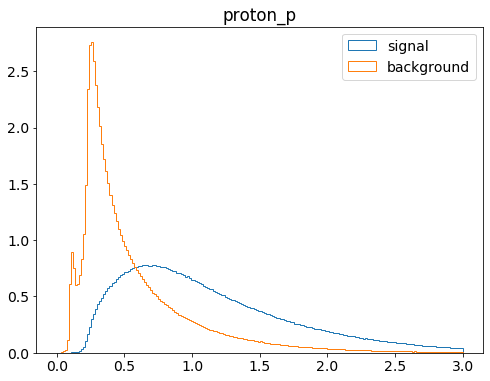

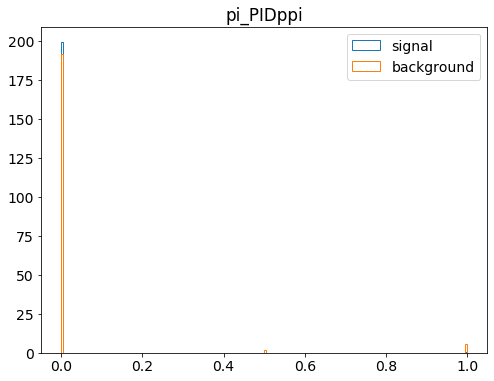

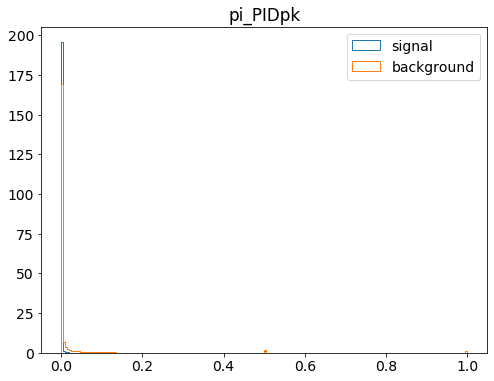

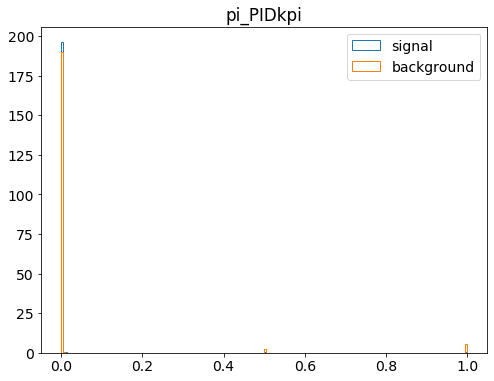

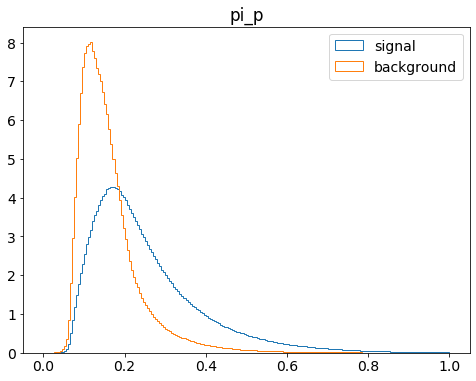

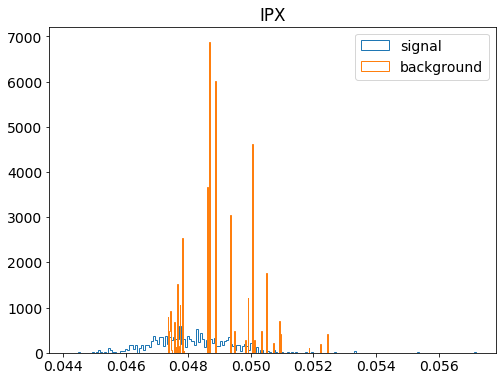

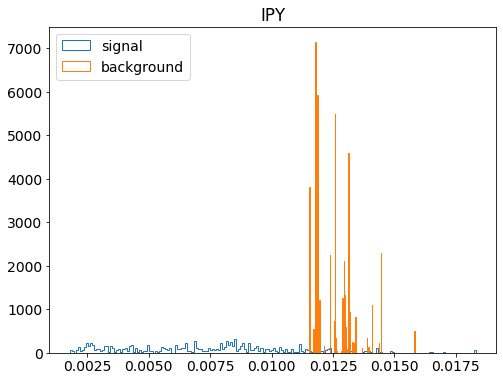

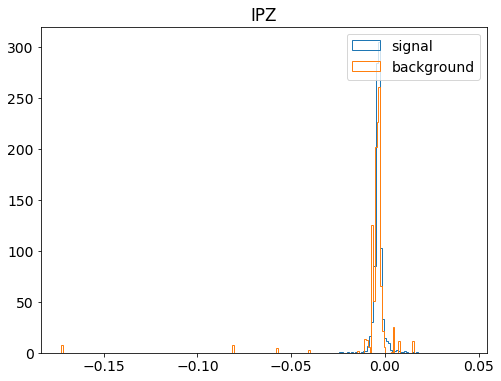

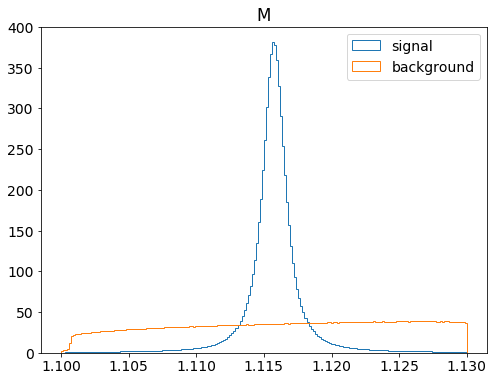

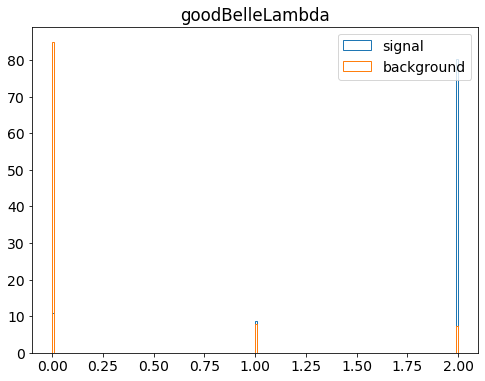

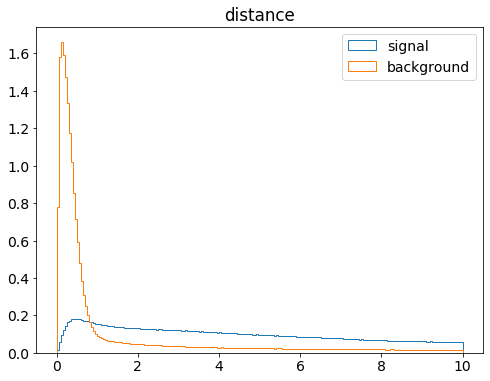

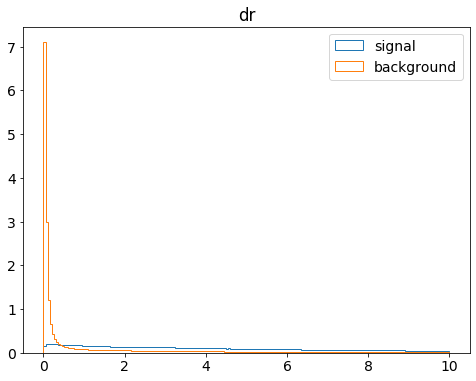

In [46]:
plot_sig_bkg(sig, bkg)

## Make training set

5M signals and 5M backgrounds with 20% as test set.

In [11]:
from sklearn.model_selection import train_test_split

sig_size = 3000000
bkg_size = 3000000

train_sig, test_sig = train_test_split(sig.sample(sig_size), test_size = 0.2)
train_bkg, test_bkg = train_test_split(bkg.sample(bkg_size), test_size = 0.2)

train = train_sig.append(train_bkg)
test = test_sig.append(test_bkg)

In [12]:
train.shape, test.shape

((4800000, 33), (1200000, 33))

In [13]:
train.head()

,__experiment__,__run__,__event__,__candidate__,__ncandidates__,__weight__,dr,dz,cosaXY,min_dr,min_dz,pt,pz,chiProb,p,proton_PIDppi,proton_PIDpk,proton_PIDkpi,proton_p,pi_PIDppi,pi_PIDpk,pi_PIDkpi,pi_p,isSignal,isPrimarySignal,mcPDG,genMotherPDG,IPX,IPY,IPZ,M,goodBelleLambda,distance
5292798,55,872,2323,0,1,1.0,10.709548,-3.663300,1.000000,10.715015,3.627405,1.064152,-0.289281,0.964729,1.102770,1.000000,0.999999,0.999988,1.040502,0.001000,0.001,0.001000,0.082362,1.0,0.0,3122.0,3322.0,0.046688,0.006843,-0.006730,1.117851,2.0,11.318754
4373808,55,638,8963,0,1,1.0,24.830253,-0.851255,1.000000,25.975872,0.614880,1.973038,-0.101062,0.767025,1.975624,0.184087,0.216070,0.450120,1.828721,0.001000,0.001,0.001000,0.160357,1.0,1.0,-3122.0,10022.0,0.046821,0.011158,-0.002526,1.113913,2.0,24.844841
3294464,55,245,117936,0,1,1.0,2.766628,3.496176,0.999991,2.760041,3.483733,0.842854,0.916850,0.794828,1.245398,0.999999,0.999999,0.998610,0.922747,0.001005,0.001,0.001005,0.324431,1.0,1.0,3122.0,10022.0,0.049313,0.004937,-0.004050,1.115631,2.0,4.458417
2055544,55,986,100414,0,1,1.0,27.459685,52.258670,1.000000,26.999851,51.256125,1.709414,3.285788,0.045537,3.703849,0.999958,0.980831,0.999292,3.331052,0.001005,0.001,0.001005,0.394279,1.0,1.0,3122.0,4122.0,0.049853,0.008723,-0.003547,1.113258,2.0,59.033913
3841252,55,494,260585,0,1,1.0,13.028187,22.993499,1.000000,13.145144,23.128716,1.953620,3.523973,0.170256,4.029270,0.970521,0.801560,0.890716,3.263416,0.000131,0.001,0.001131,0.774119,1.0,1.0,-3122.0,-3224.0,0.046121,0.008250,-0.004424,1.117747,2.0,26.427914


In [14]:
test.head()

,__experiment__,__run__,__event__,__candidate__,__ncandidates__,__weight__,dr,dz,cosaXY,min_dr,min_dz,pt,pz,chiProb,p,proton_PIDppi,proton_PIDpk,proton_PIDkpi,proton_p,pi_PIDppi,pi_PIDpk,pi_PIDkpi,pi_p,isSignal,isPrimarySignal,mcPDG,genMotherPDG,IPX,IPY,IPZ,M,goodBelleLambda,distance
151789,55,455,2633,0,1,1.0,7.586846,13.523061,0.789074,7.517095,13.068618,0.310126,0.537761,0.561525,0.620778,0.999005,0.999000,0.501361,0.522157,0.001000,0.001,0.001000,0.145962,1.0,0.0,3122.0,-321.0,0.048587,0.010351,-0.007387,1.116708,0.0,15.505915
3787749,55,478,141520,0,1,1.0,6.511962,0.634068,0.999959,6.551112,0.601397,0.777078,0.069599,0.223968,0.780188,0.999999,0.999999,0.498594,0.560949,0.001000,0.001,0.001000,0.224787,1.0,1.0,3122.0,3114.0,0.046344,0.007650,-0.004603,1.114406,2.0,6.542759
5900723,55,988,91192,1,2,1.0,0.572107,0.970685,0.999564,0.567976,0.461924,0.984727,1.256597,0.179801,1.596472,0.998120,0.999960,0.020870,1.420112,0.001000,0.001,0.001000,0.204504,1.0,1.0,3122.0,3214.0,0.050040,0.008739,-0.003202,1.117533,2.0,1.126737
5149430,55,842,99993,0,1,1.0,6.654112,6.060635,0.998188,6.682689,6.030680,0.462991,0.397815,0.189201,0.610424,0.998878,0.999000,0.471247,0.471018,0.001000,0.001,0.001000,0.158202,1.0,1.0,-3122.0,-3214.0,0.046092,0.002748,-0.005445,1.113197,1.0,9.000472
5155531,55,844,80245,0,1,1.0,16.958927,15.798630,0.999999,16.687813,15.464881,1.841028,1.680467,0.924825,2.492660,0.750169,0.754679,0.493947,1.991829,0.000001,0.500,0.000001,0.505829,1.0,1.0,3122.0,3224.0,0.046009,0.002802,-0.005624,1.115505,2.0,23.177616


In [15]:
train.to_root('../data/train_balanced.root', 'lambda')

In [16]:
test.to_root('../data/test_balanced.root', 'lambda')

## Make nonhyperon signal

In [44]:
train = read_root('../data/train_balanced.root', 'lambda')
test = read_root('../data/test_balanced.root', 'lambda')

In [45]:
import pdg
import numpy as np

In [46]:
pdg.from_names(['Xi-', 'Xi0'])

[3312, 3322]

In [47]:
def is_from_hyperon(motherPDG):
    return (np.abs(motherPDG) == 3312) | (np.abs(motherPDG) == 3322)

In [48]:
train['isLambda'] = train.isSignal.copy()
train['isSignal'] = (train.isLambda == 1) & ~ is_from_hyperon(train.genMotherPDG)
train.isSignal = train.isSignal.astype('float')
sum(train.isSignal), sum(train.isLambda)

(1707812.0, 2000000.0)

In [40]:
train.head()

,M,p,isSignal,isPrimarySignal,genMotherPDG,mcPDG,p_p,pi_p,p_pid_ppi,p_pid_pk,min_daug_d0,min_daug_z0,abs_dr,abs_dz,distance,chiProb,cosaXY,goodLambda,goodBelleLambda,isLambda
1029035,1.117408,2.489676,1.0,1.0,10022.0,-3122.0,2.257350,0.241783,0.909631,0.167949,5.604032,0.507845,21.864474,36.398803,42.460901,0.220902,0.999999,-999.0,2.0,True
1035383,1.114480,0.987419,1.0,1.0,4122.0,3122.0,0.784920,0.224331,0.999999,0.999999,2.987833,0.326523,6.654085,0.466845,6.670442,0.019982,0.999985,-999.0,2.0,True
2356216,1.114613,1.384552,1.0,1.0,10022.0,-3122.0,1.060436,0.332552,0.999989,0.999999,0.059212,1.567723,4.278639,1.915160,4.687706,0.926968,0.999998,-999.0,2.0,True
895772,1.107335,2.739998,1.0,1.0,-4122.0,-3122.0,2.390466,0.352692,0.993984,0.979881,2.279973,2.028538,23.838575,14.034329,27.662973,0.006640,-0.999997,-999.0,0.0,True
2849343,1.115206,1.933468,1.0,1.0,3212.0,3122.0,1.717163,0.237227,0.999957,0.999961,0.065425,0.255078,0.643160,0.230329,0.683159,0.786925,0.999803,-999.0,2.0,True


In [49]:
test['isLambda'] = test.isSignal.copy()
test['isSignal'] = (test.isLambda == 1) & ~ is_from_hyperon(test.genMotherPDG)
test.isSignal = test.isSignal.astype('float')
sum(test.isSignal), sum(test.isLambda)

(427349.0, 500000.0)

In [50]:
train.to_root('../data/train_balanced_nohyperon.root', 'lambda')
test.to_root('../data/test_balanced_nohyperon.root', 'lambda')